In [1]:
import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape, LeakyReLU, Dropout, Input
from keras.layers import Activation, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import Embedding, Multiply, Concatenate # CGAN
from keras import regularizers

from keras.models import Model, Sequential
from keras.optimizers import Adam

# Preprocessing:

## Load Dataset:

In [2]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


## Concat train & test data:

In [3]:
# to have more data for train
real_data = np.concatenate([x_train, x_test], axis=0)
real_labels = np.concatenate([y_train, y_test], axis=0)
print(real_data.shape)
print(real_labels.shape)

(70000, 28, 28)
(70000,)


## Normalize & Extend(dim) data:

In [4]:
normalized_real_data = np.expand_dims(real_data/127.5 - 1.0, axis=3)

# Define Networks:

In [5]:
def generator(zdim):
    """ Generator Network """
    model = Sequential()

    model.add(Dense(7*7*256, use_bias=False, input_shape=(zdim,))) # >>> (12544, 1, 1)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256))) # >>> (7, 7, 256)

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)) # >>> (7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)) # >>> (14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')) # >>> (28, 28, 1)

    return model

def cgenerator(zdim, num_classes):
    """ Conditional Generator Network """
    z = Input(shape=(zdim,))
    label = Input(shape=(1,), dtype='int32')

    label_emb = Embedding(num_classes, zdim, input_length=1)(label)
    # >>> (batch_size, 1, 100)

    label_emb = Flatten()(label_emb)
    # >>> (batch_size, 100)

    model_input = Multiply()([z, label_emb])

    model = generator(zdim)
    img = model(model_input)

    return Model([z, label], img)


In [6]:
def discriminator(img_shape):
    """ Discriminator Network """
    model = Sequential()

    # Input >>> (28, 28, 2)
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=img_shape)) # >>> (14, 14, 64)
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same')) # >>> (7, 7, 128)
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten()) # >>> 7 * 7 * 128
    model.add(Dense(1, activation='sigmoid'))

    return model

def cdiscriminator(img_shape, num_classes):
    """ Conditional Discriminator Network """
    img = Input(shape=img_shape)
    label = Input(shape=(1,), dtype='int32')

    label_emb = Embedding(num_classes, np.prod(img_shape), input_length=1)(label)
    # >>> (batch_size, 1, 28 * 28 * 1)

    label_emb = Flatten()(label_emb)
    # >>> (batch_size, 28 * 28 * 1)

    label_emb = Reshape(img_shape)(label_emb)
    # >>> (batch_size, 28, 28, 1)

    concat_img = Concatenate(axis=-1)([img, label_emb])
    # >>> (batch_size, 28, 28, 2) --> concat in depth channel

    d_model = discriminator(img_shape=concat_img.shape[1:])
    classification = d_model(concat_img)

    model = Model([img, label], classification)

    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model

In [7]:
def define_cgan(gen, dis, zdim, num_classes):
    z = Input(shape=(zdim,))
    label = Input(shape=(1,), dtype='int32')

    f_img = gen([z, label])
    classification = dis([f_img, label])

    model = Model([z, label], classification)

    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer
    )

    return model


## Set Shapes:

In [8]:
z_dim = 100
num_classes = 10
img_shape = (real_data.shape[1], real_data.shape[2], 1) # (28, 28, 1)
img_shape

(28, 28, 1)

## Call Networks:

In [9]:
cdis = cdiscriminator(img_shape, num_classes)
cgen = cgenerator(z_dim, num_classes)

cdis.trainable = False
CGAN = define_cgan(cgen, cdis, z_dim, num_classes)

# Train Model:

## Useful Tools:

In [10]:
def show_images(gen, zdim):
    """ Show output samples """
    z = np.random.normal(0, 1, (10, zdim))
    labels = np.arange(0, 10).reshape(-1, 1)

    gen_imgs = gen.predict([z, labels])
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(2, 5, figsize=(10, 4), sharey=True, sharex=True)

    c = 0
    for i in range(2):
        for j in range(5):
            axs[i, j].imshow(gen_imgs[c], cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title("Class: %d" % labels[c], weight='bold')
            c += 1

    plt.tight_layout()
    plt.show()

## Define operation algorithm:

In [11]:
losses = []
accuracies = []
iter_checks = []

def train(r_data, data_labels, gen, dis, GAN, zdim, iters_range, batch_size, interval):
    r_labels = np.ones((batch_size, 1))
    f_labels = np.zeros((batch_size, 1))

    for iter in range(iters_range):
        print(f"------------------{iter+1}------------------")
        random_index_array = np.random.randint(0, r_data.shape[0], batch_size) # array of random indexs
        r_imgs = r_data[random_index_array]
        d_labels = data_labels[random_index_array]

        z = np.random.normal(0, 1, (batch_size, zdim))
        f_imgs = gen.predict([z, d_labels])

        r_dloss = dis.train_on_batch([r_imgs, d_labels], r_labels)
        f_dloss = dis.train_on_batch([f_imgs, d_labels], f_labels)

        dloss, acc = np.add(r_dloss, f_dloss) * 0.5

        z = np.random.normal(0, 1, (batch_size, zdim))
        random_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
        gloss = GAN.train_on_batch([z, random_labels], r_labels)

        if (iter + 1) % interval == 0:
            losses.append((dloss, gloss))
            accuracies.append(100.0*acc)
            iter_checks.append(iter+1)

            print(
                "%d --> D loss[%f] acc[%.2f] | G loss[f]"
                % (iter + 1, dloss, 100.0 * acc)
            )

            show_images(gen, zdim)


## Start training:

------------------1------------------
8/8 [==============================] - 0s 18ms/step
------------------2------------------
8/8 [==============================] - 0s 14ms/step
------------------3------------------
8/8 [==============================] - 0s 13ms/step
------------------4------------------
8/8 [==============================] - 0s 13ms/step
------------------5------------------
8/8 [==============================] - 0s 14ms/step
------------------6------------------
8/8 [==============================] - 0s 13ms/step
------------------7------------------
8/8 [==============================] - 0s 13ms/step
------------------8------------------
8/8 [==============================] - 0s 13ms/step
------------------9------------------
8/8 [==============================] - 0s 13ms/step
------------------10------------------
8/8 [==============================] - 0s 13ms/step
------------------11------------------
8/8 [==============================] - 0s 13ms/step
--------

<ipython-input-10-4903a8e03f12>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axs[i, j].set_title("Class: %d" % labels[c], weight='bold')


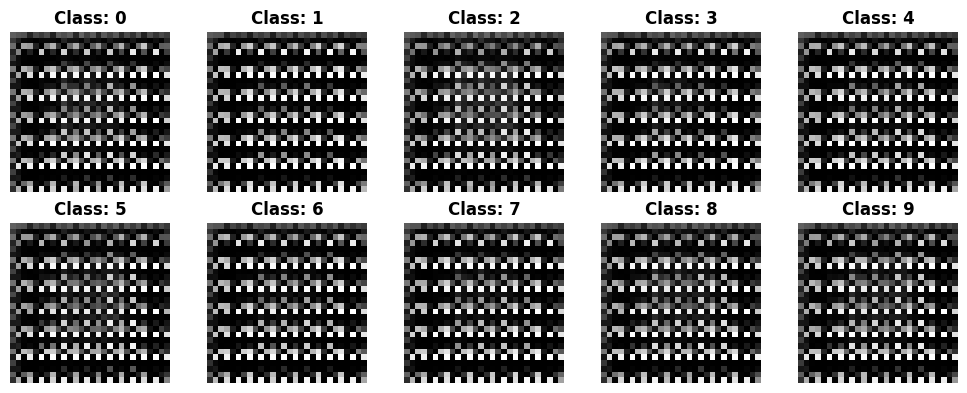

------------------501------------------
8/8 [==============================] - 0s 12ms/step
------------------502------------------
8/8 [==============================] - 0s 13ms/step
------------------503------------------
8/8 [==============================] - 0s 12ms/step
------------------504------------------
8/8 [==============================] - 0s 12ms/step
------------------505------------------
8/8 [==============================] - 0s 12ms/step
------------------506------------------
8/8 [==============================] - 0s 13ms/step
------------------507------------------
8/8 [==============================] - 0s 11ms/step
------------------508------------------
8/8 [==============================] - 0s 11ms/step
------------------509------------------
8/8 [==============================] - 0s 13ms/step
------------------510------------------
8/8 [==============================] - 0s 12ms/step
------------------511------------------
8/8 [==============================] - 0

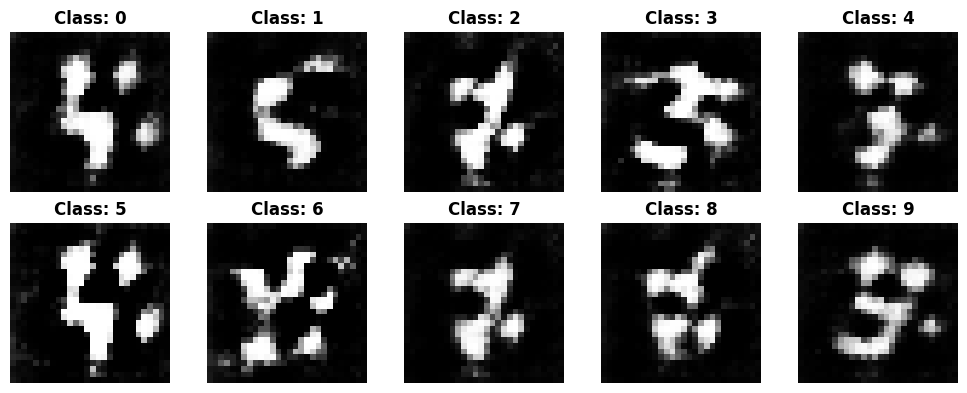

------------------1001------------------
8/8 [==============================] - 0s 12ms/step
------------------1002------------------
8/8 [==============================] - 0s 12ms/step
------------------1003------------------
8/8 [==============================] - 0s 13ms/step
------------------1004------------------
8/8 [==============================] - 0s 13ms/step
------------------1005------------------
8/8 [==============================] - 0s 13ms/step
------------------1006------------------
8/8 [==============================] - 0s 13ms/step
------------------1007------------------
8/8 [==============================] - 0s 13ms/step
------------------1008------------------
8/8 [==============================] - 0s 13ms/step
------------------1009------------------
8/8 [==============================] - 0s 12ms/step
------------------1010------------------
8/8 [==============================] - 0s 12ms/step
------------------1011------------------
8/8 [========================

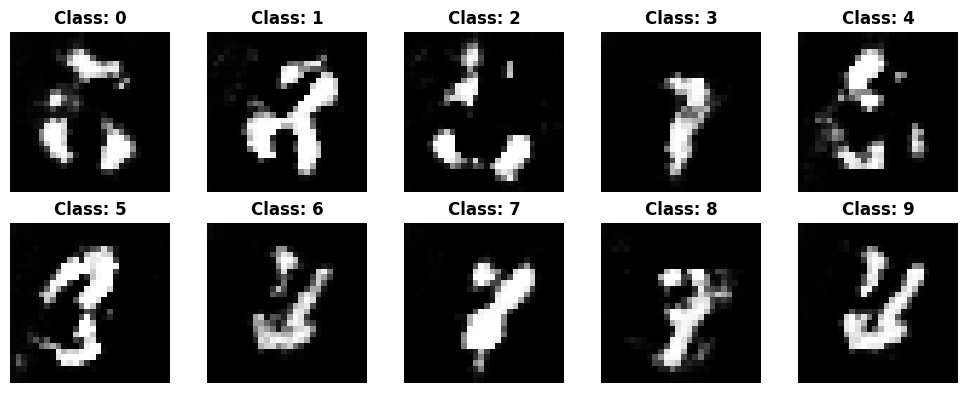

------------------1501------------------
8/8 [==============================] - 0s 13ms/step
------------------1502------------------
8/8 [==============================] - 0s 12ms/step
------------------1503------------------
8/8 [==============================] - 0s 13ms/step
------------------1504------------------
8/8 [==============================] - 0s 13ms/step
------------------1505------------------
8/8 [==============================] - 0s 14ms/step
------------------1506------------------
8/8 [==============================] - 0s 12ms/step
------------------1507------------------
8/8 [==============================] - 0s 13ms/step
------------------1508------------------
8/8 [==============================] - 0s 14ms/step
------------------1509------------------
8/8 [==============================] - 0s 14ms/step
------------------1510------------------
8/8 [==============================] - 0s 15ms/step
------------------1511------------------
8/8 [========================

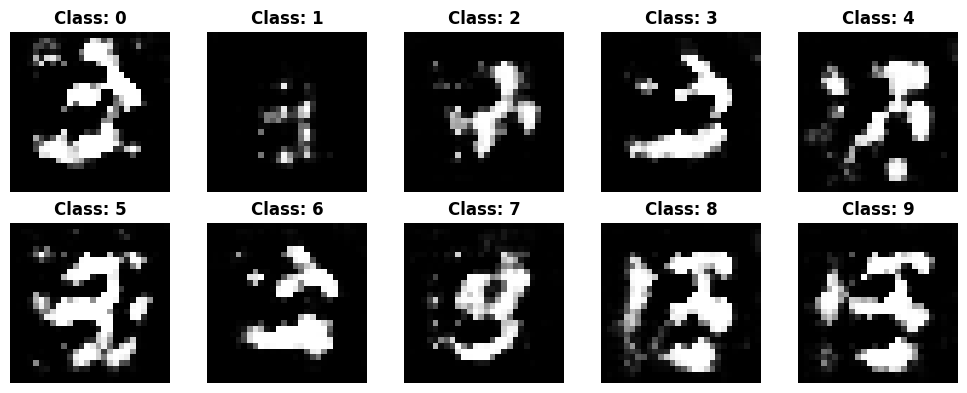

------------------2001------------------
8/8 [==============================] - 0s 13ms/step
------------------2002------------------
8/8 [==============================] - 0s 12ms/step
------------------2003------------------
8/8 [==============================] - 0s 13ms/step
------------------2004------------------
8/8 [==============================] - 0s 13ms/step
------------------2005------------------
8/8 [==============================] - 0s 13ms/step
------------------2006------------------
8/8 [==============================] - 0s 13ms/step
------------------2007------------------
8/8 [==============================] - 0s 12ms/step
------------------2008------------------
8/8 [==============================] - 0s 12ms/step
------------------2009------------------
8/8 [==============================] - 0s 13ms/step
------------------2010------------------
8/8 [==============================] - 0s 13ms/step
------------------2011------------------
8/8 [========================

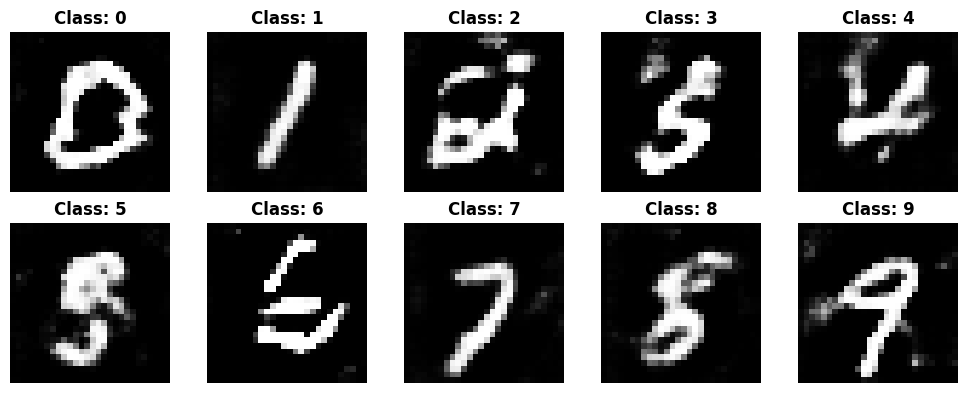

------------------2501------------------
8/8 [==============================] - 0s 13ms/step
------------------2502------------------
8/8 [==============================] - 0s 13ms/step
------------------2503------------------
8/8 [==============================] - 0s 13ms/step
------------------2504------------------
8/8 [==============================] - 0s 14ms/step
------------------2505------------------
8/8 [==============================] - 0s 13ms/step
------------------2506------------------
8/8 [==============================] - 0s 13ms/step
------------------2507------------------
8/8 [==============================] - 0s 14ms/step
------------------2508------------------
8/8 [==============================] - 0s 13ms/step
------------------2509------------------
8/8 [==============================] - 0s 12ms/step
------------------2510------------------
8/8 [==============================] - 0s 14ms/step
------------------2511------------------
8/8 [========================

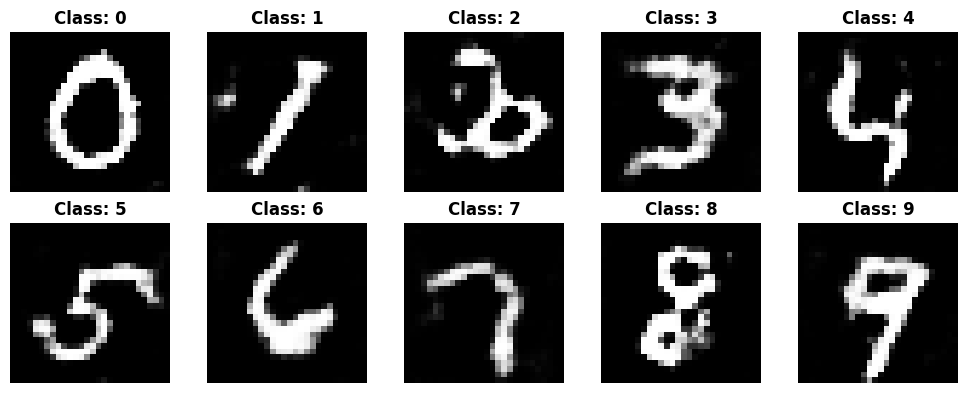

------------------3001------------------
8/8 [==============================] - 0s 14ms/step
------------------3002------------------
8/8 [==============================] - 0s 13ms/step
------------------3003------------------
8/8 [==============================] - 0s 12ms/step
------------------3004------------------
8/8 [==============================] - 0s 13ms/step
------------------3005------------------
8/8 [==============================] - 0s 12ms/step
------------------3006------------------
8/8 [==============================] - 0s 13ms/step
------------------3007------------------
8/8 [==============================] - 0s 13ms/step
------------------3008------------------
8/8 [==============================] - 0s 12ms/step
------------------3009------------------
8/8 [==============================] - 0s 13ms/step
------------------3010------------------
8/8 [==============================] - 0s 13ms/step
------------------3011------------------
8/8 [========================

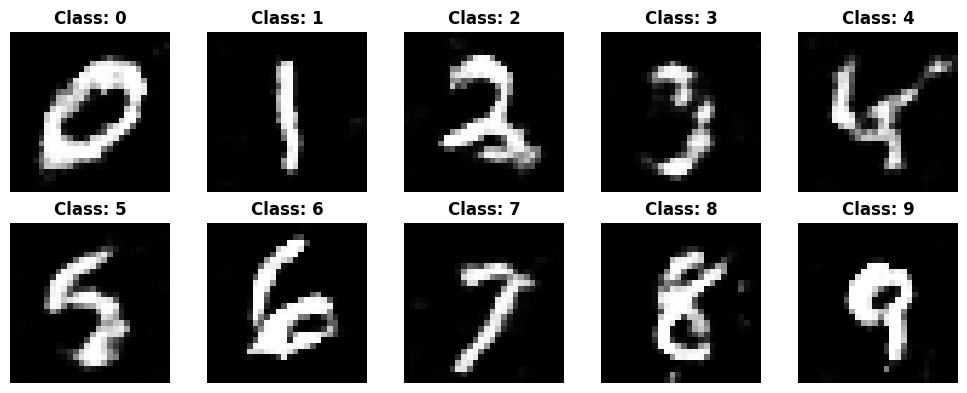

------------------3501------------------
8/8 [==============================] - 0s 12ms/step
------------------3502------------------
8/8 [==============================] - 0s 14ms/step
------------------3503------------------
8/8 [==============================] - 0s 13ms/step
------------------3504------------------
8/8 [==============================] - 0s 13ms/step
------------------3505------------------
8/8 [==============================] - 0s 13ms/step
------------------3506------------------
8/8 [==============================] - 0s 12ms/step
------------------3507------------------
8/8 [==============================] - 0s 14ms/step
------------------3508------------------
8/8 [==============================] - 0s 12ms/step
------------------3509------------------
8/8 [==============================] - 0s 14ms/step
------------------3510------------------
8/8 [==============================] - 0s 12ms/step
------------------3511------------------
8/8 [========================

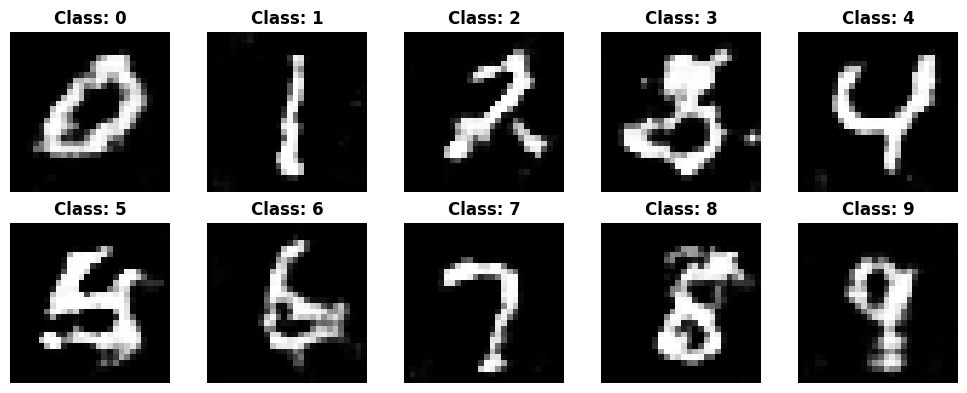

------------------4001------------------
8/8 [==============================] - 0s 13ms/step
------------------4002------------------
8/8 [==============================] - 0s 14ms/step
------------------4003------------------
8/8 [==============================] - 0s 13ms/step
------------------4004------------------
8/8 [==============================] - 0s 12ms/step
------------------4005------------------
8/8 [==============================] - 0s 13ms/step
------------------4006------------------
8/8 [==============================] - 0s 13ms/step
------------------4007------------------
8/8 [==============================] - 0s 12ms/step
------------------4008------------------
8/8 [==============================] - 0s 13ms/step
------------------4009------------------
8/8 [==============================] - 0s 14ms/step
------------------4010------------------
8/8 [==============================] - 0s 12ms/step
------------------4011------------------
8/8 [========================

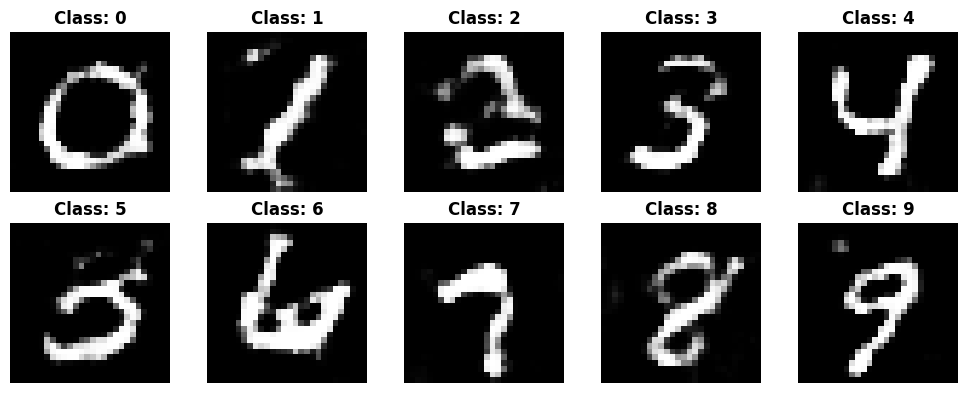

------------------4501------------------
8/8 [==============================] - 0s 13ms/step
------------------4502------------------
8/8 [==============================] - 0s 15ms/step
------------------4503------------------
8/8 [==============================] - 0s 13ms/step
------------------4504------------------
8/8 [==============================] - 0s 14ms/step
------------------4505------------------
8/8 [==============================] - 0s 14ms/step
------------------4506------------------
8/8 [==============================] - 0s 14ms/step
------------------4507------------------
8/8 [==============================] - 0s 13ms/step
------------------4508------------------
8/8 [==============================] - 0s 13ms/step
------------------4509------------------
8/8 [==============================] - 0s 13ms/step
------------------4510------------------
8/8 [==============================] - 0s 12ms/step
------------------4511------------------
8/8 [========================

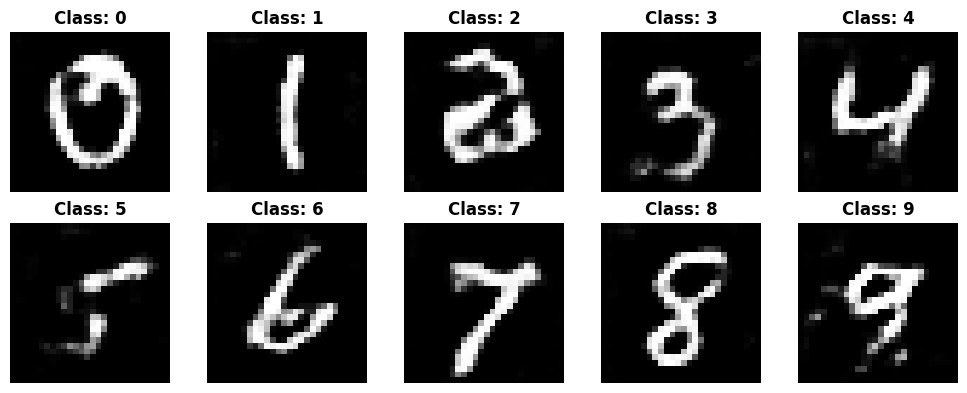

In [12]:
train(normalized_real_data, real_labels, cgen, cdis, CGAN, z_dim, 5000, 256, 500)

In [13]:
cgen.save("numbers_generator_CGAN_mnist_70000.keras")

# ***FIN :3***